# Model visualization

In this notebook we examine in a layer-by-layer fashion carcass interpolation model. We show the intermediate activations, as well as learned features, visualized by the [GradCam](https://arxiv.org/abs/1610.02391) and [DeepDream-like](https://github.com/google/deepdream) techniques.

In [1]:
# Necessary imports
import os
import sys
import warnings

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

sys.path.append('../..')
from seismiqb.batchflow import Pipeline, FilesIndex, B, D
from seismiqb.batchflow.models.torch import EncoderDecoder

from seismiqb import SeismicCubeset, plot_image

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# Global parameters
CROP_SHAPE = (1, 256, 256)       # shape of sampled 3D crops

SAVEDIR = 'model_visualization'  # directory to save images to
!rm -rf {SAVEDIR}
!mkdir {SAVEDIR}

In [3]:
def visualize_grid(images, layout=(4, 4), figsize=(6, 6), cmap='viridis', savepath=None):
    """ Plot multiple images on a grid with defined layout. """
    means = [np.mean(item) for item in images]
    indices = np.argsort(means)[::-1][:layout[0]*layout[1]]

    fig, ax = plt.subplots(*layout, figsize=(figsize[0]*layout[1], figsize[1]*layout[0]))

    for i, idx in enumerate(indices):
        img = images[idx]

        current_axis = ax[i // layout[1], i % layout[1]]
        current_axis.imshow(img.T, cmap=cmap)
        current_axis.set_title(f'Index {idx}')
        
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0, dpi=100)

# Dataset

Next, we define the dataset and pipeline with the trained model. Note that we load the ground truth horizon and obtain model predictions on the fly.

In [4]:
cube_path = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5'
horizon_path = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_B_anon'

dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load_geometries()
dataset.create_labels({dataset.indices[0]: [horizon_path]})

dataset.create_sampler(quality_grid=False)
dataset.modify_sampler('test_sampler', finish=True)

In [5]:
pipeline = (
    Pipeline()
    # Load model from the disk
    .init_model('static', 'model', EncoderDecoder,
                {'load/path': 'models/01_demo_model'})

    # Load data/masks
    .make_locations(points=D('test_sampler')(1),
          shape=CROP_SHAPE, side_view=True)
    .create_masks(dst='masks', width=4)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'], shape=CROP_SHAPE)
    .normalize(mode='q', src='images')
    
    # Make model prediction
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=B('predictions'))
) << dataset

model = pipeline.m('model')
batch = pipeline.next_batch(D.size)

# Activations

First of all, we want to visualize intermediate layer outputs. We do so for multiple layers in the model:

* `initial_block`
* `encoder: block-1`
* `embedding`

## Activations: initial_block

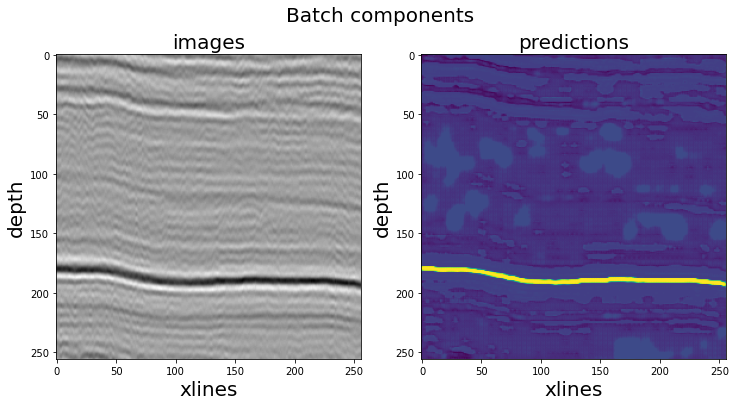

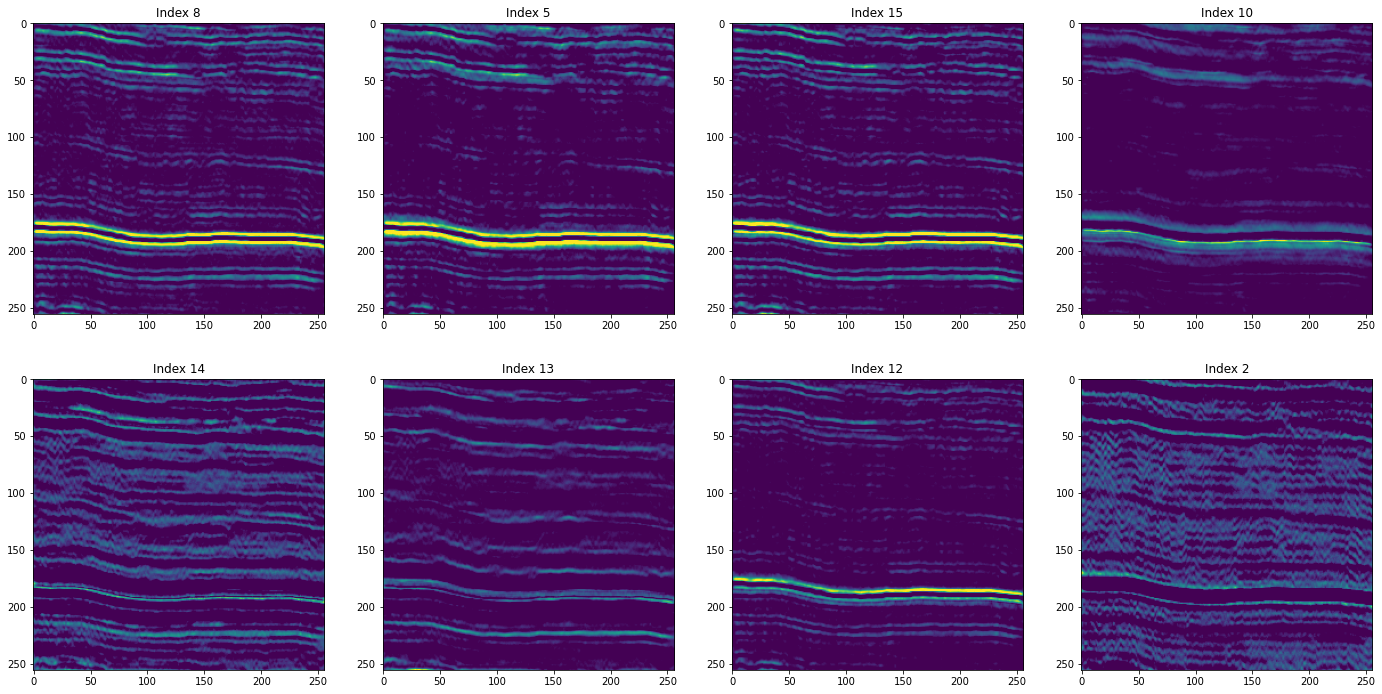

In [6]:
module = model.model[0]

batch.plot_components('images', 'predictions', idx=0, mode='separate')

activations = model.get_intermediate_activations(images=batch.images, layers=module)

visualize_grid(activations[0], layout=(2, 4),
               savepath=f'{SAVEDIR}/activation_ib')

## Activations: encoder block-1

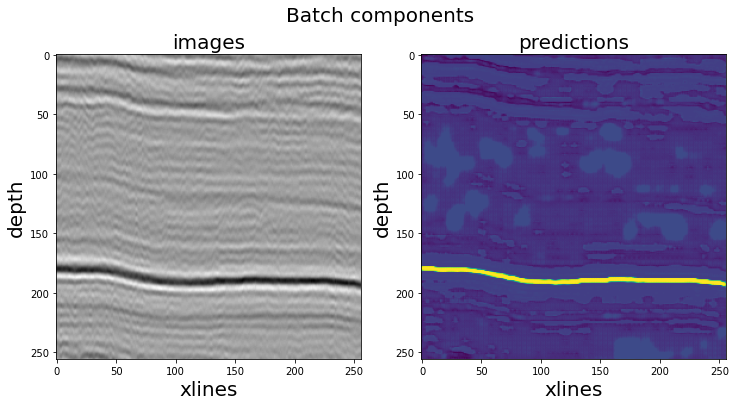

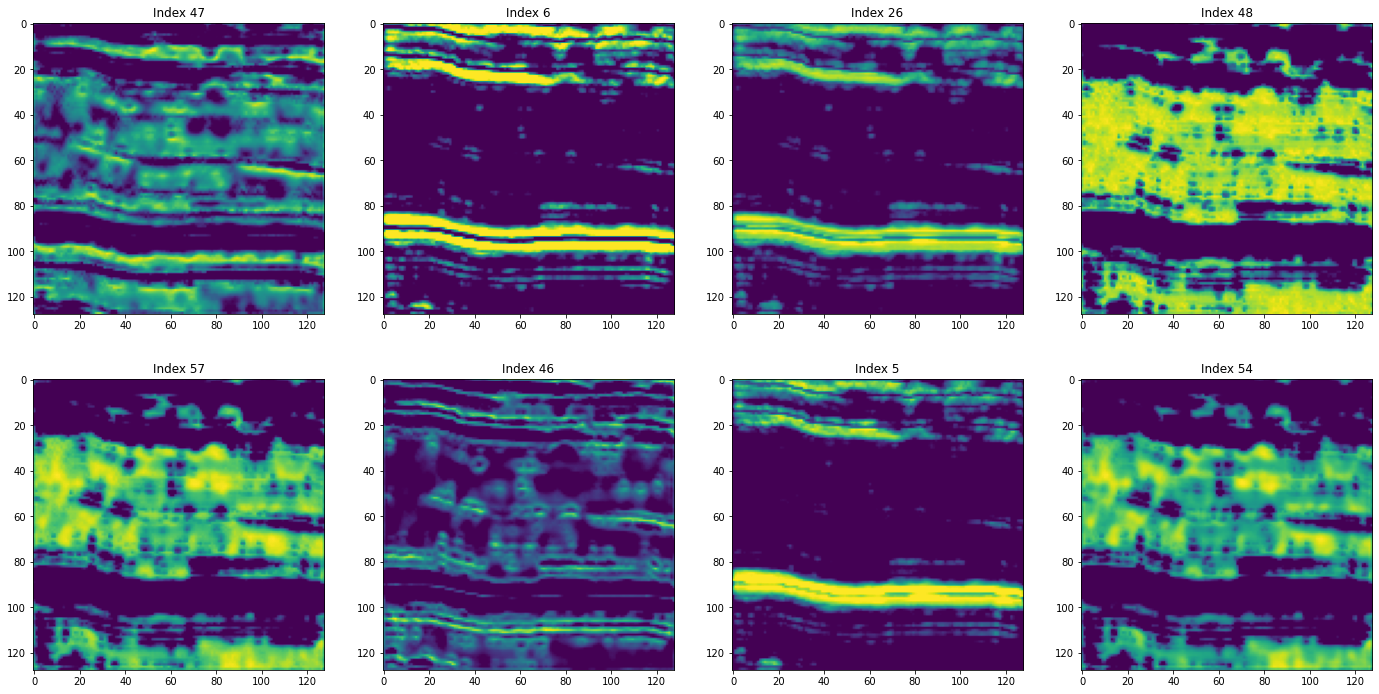

In [7]:
module = model.model[1][0]['block-1']

batch.plot_components('images', 'predictions', idx=0, mode='separate')

activations = model.get_intermediate_activations(images=batch.images, layers=module)

visualize_grid(activations[0], layout=(2, 4),
               savepath=f'{SAVEDIR}/activation_encoder_1')

Produced images provide invaluable insight into the inner workings of the neural net: we can see that some of the layers are focused on outlining the target horizon area, some of them detect noises and seismic inconsistency, some of them just track all the reflections to help the deeper layers.

## Activations: embedding

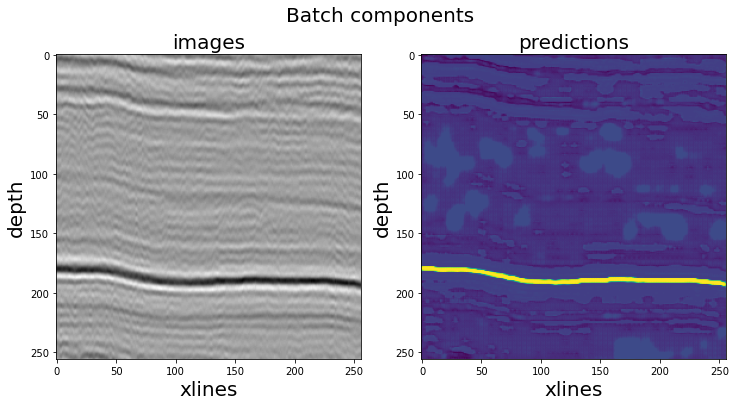

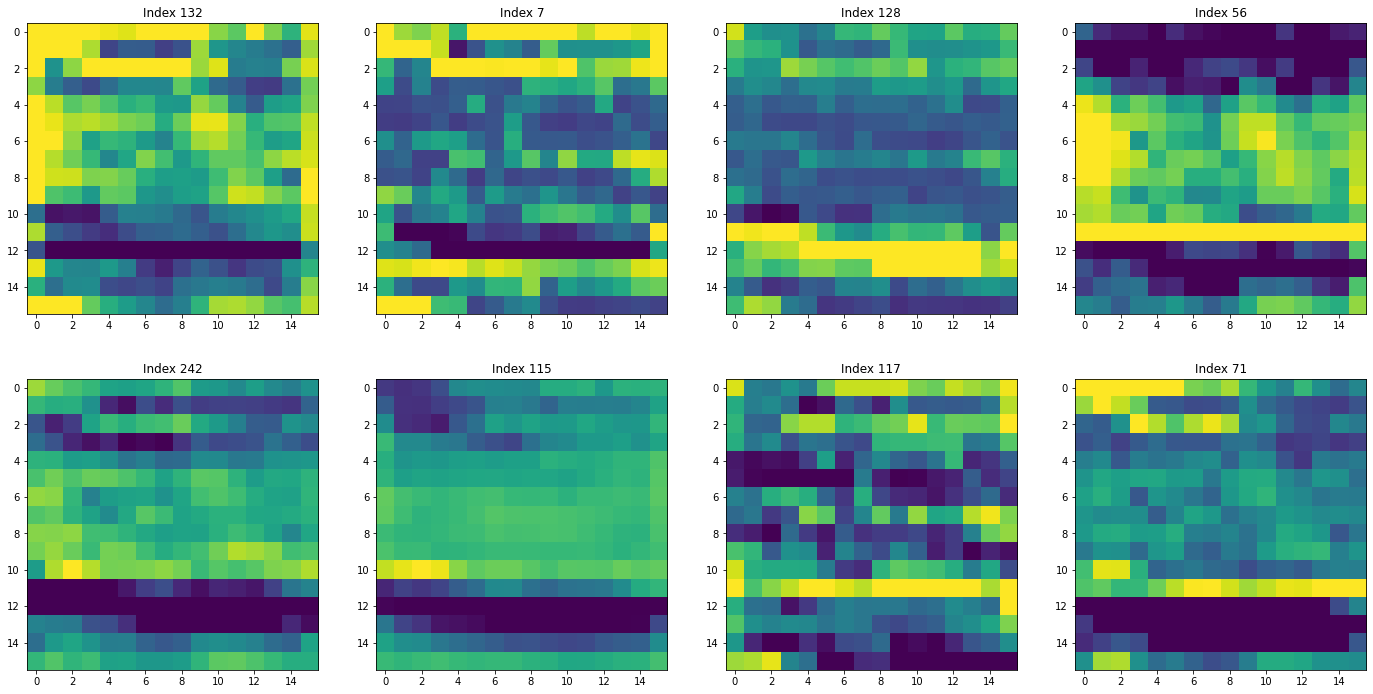

In [8]:
module = model.model[1][1]

batch.plot_components('images', 'predictions', idx=0, mode='separate')

activations = model.get_intermediate_activations(images=batch.images, layers=module)

visualize_grid(activations[0], layout=(2, 4),
               savepath=f'{SAVEDIR}/activation_embedding')

# Texture

Now is the time to create a visual representation of the layer. To do so, we generate a random image as the model input, and adjust it to maximize the target layer activation. This produces the texture that this layer is recognizing at inference time.

## Texture: decoder block-0

  0%|          | 0/8 [00:00<?, ?it/s]

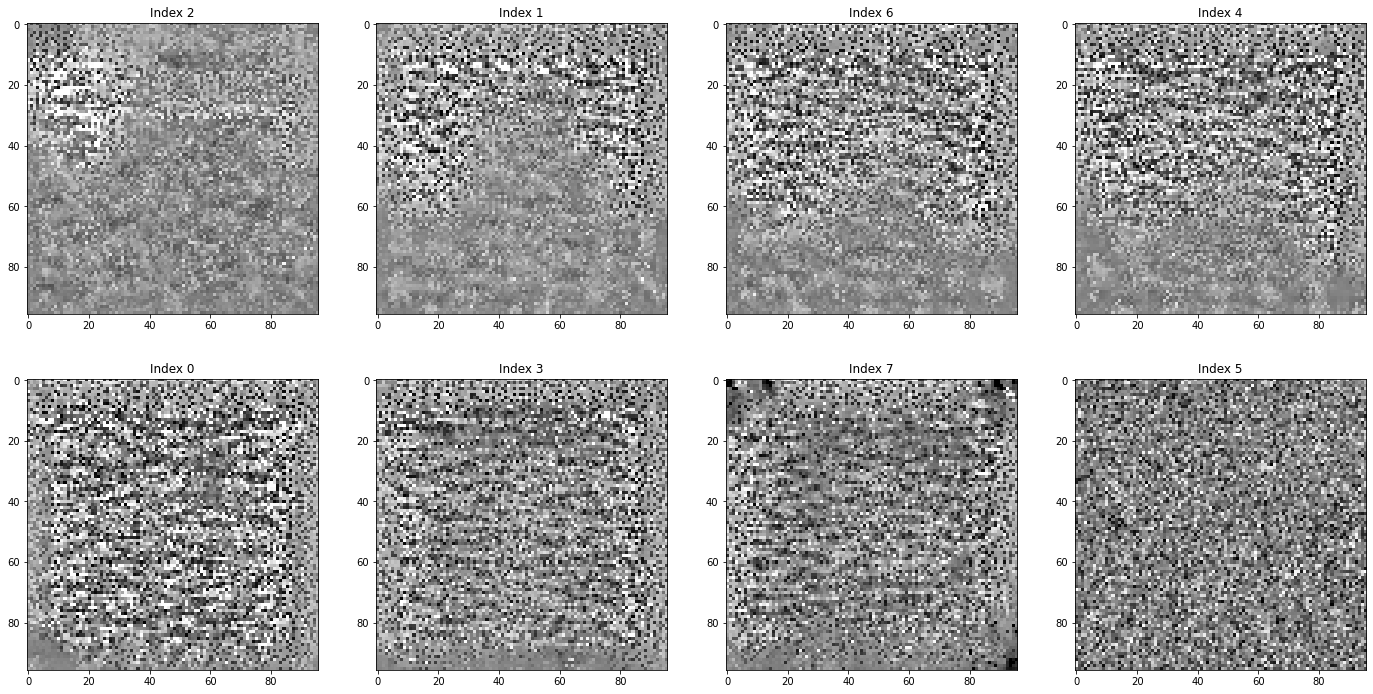

In [9]:
module = model.model[1][2]['block-0']

textures = []
for i in tqdm(range(8, 16)):
    representation = model.get_layer_representation(layer=module, input_shape=(1, 96, 96), index=i,
                                                    iters=200)
    textures.append(representation[0, 0])
    
visualize_grid(textures, layout=(2, 4), cmap='gray',
               savepath=f'{SAVEDIR}/features_decoder_0')

## Texture: head

  0%|          | 0/8 [00:00<?, ?it/s]

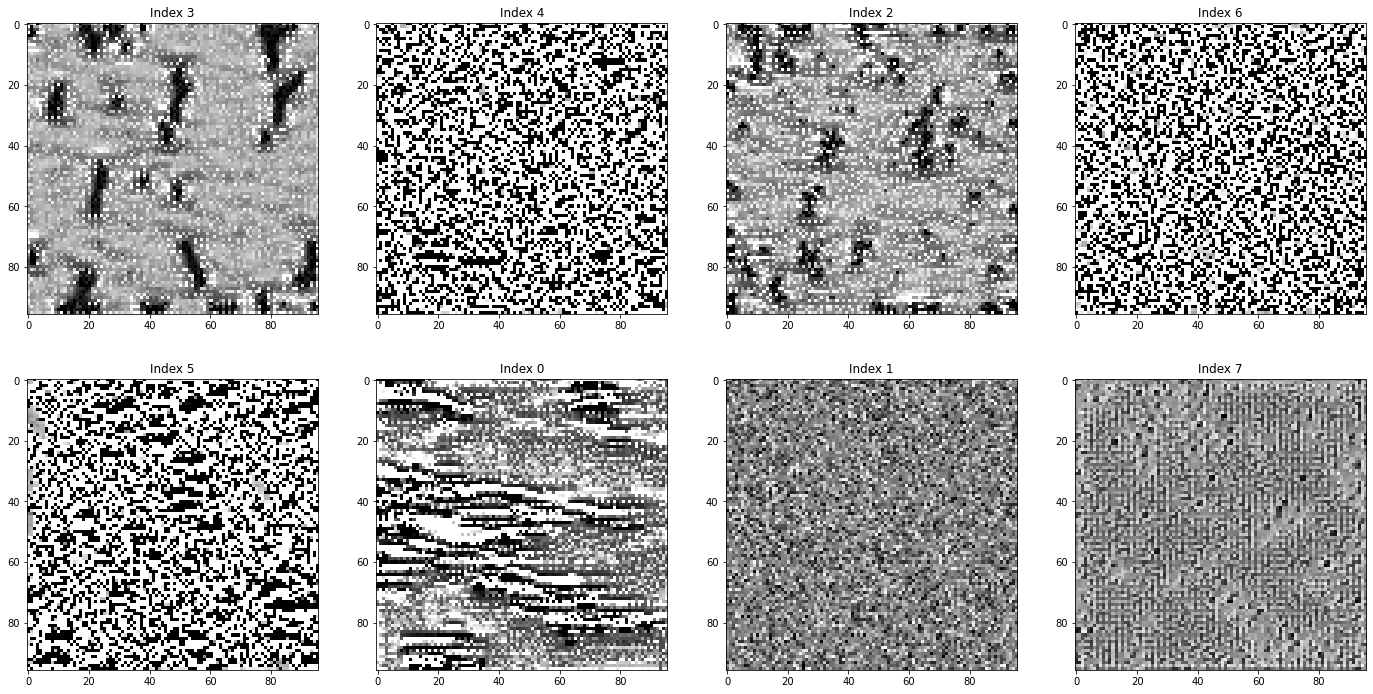

In [10]:
module = model.model[2][0]

textures = []
for i in tqdm(range(8)):
    representation = model.get_layer_representation(layer=module, input_shape=(1, 96, 96), index=i,
                                                    iters=200)
    textures.append(representation[0, 0])
    
visualize_grid(textures, layout=(2, 4), cmap='gray',
               savepath=f'{SAVEDIR}/features_head')

We can clearly see that model learns to identify horizontal changes in the seismic, as well as detecting various kinds of noise.

# GRAD CAM

Finally, we can look at the gradient, obtained from the true horizon mask and that can show the direction of improvements for neural network. That is the way to see regions of model attention, and, as we can see, it recognizes other reflections on the seismic images and uses them to make better predictions!

## GradCam: initial_block

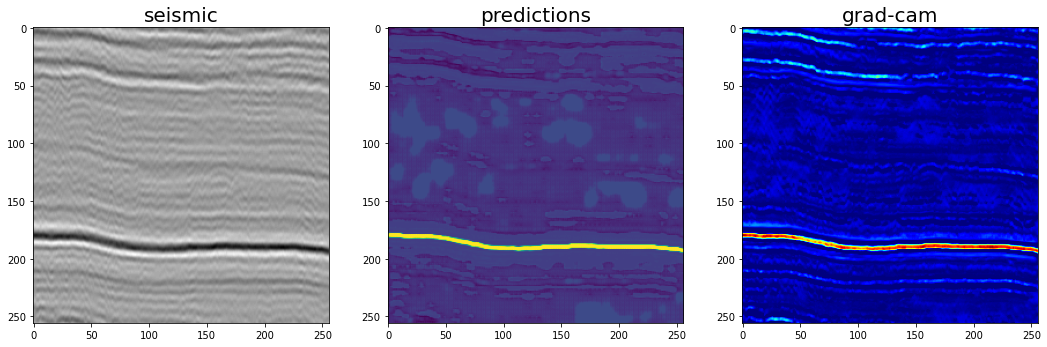

In [11]:
module = model.model[0]

cam = model.get_gradcam(images=batch.images[0:1], gradient_mode=batch.masks[0:1], layer=module)

plot_image((batch.images[0], batch.predictions[0], cam), mode='separate', cmap=['gray', 'viridis', 'jet'], t='',
           titles=['seismic', 'predictions', 'grad-cam'],
           savepath=f'{SAVEDIR}/cam_ib')

## GradCam: encoder block-0

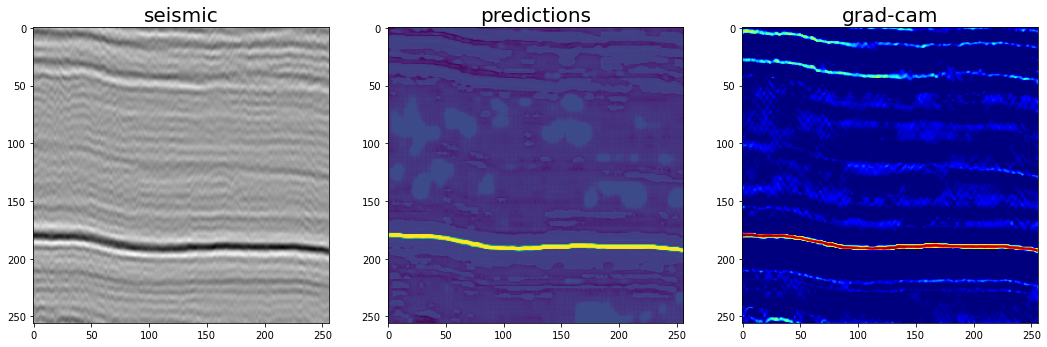

In [12]:
module = model.model[1][0]['block-0']

cam = model.get_gradcam(images=batch.images[0:1], gradient_mode=batch.masks[0:1], layer=module)

plot_image((batch.images[0], batch.predictions[0], cam), mode='separate', cmap=['gray', 'viridis', 'jet'], t='',
           titles=['seismic', 'predictions', 'grad-cam'],
           savepath=f'{SAVEDIR}/cam_encoder_0')

## GradCam: embedding

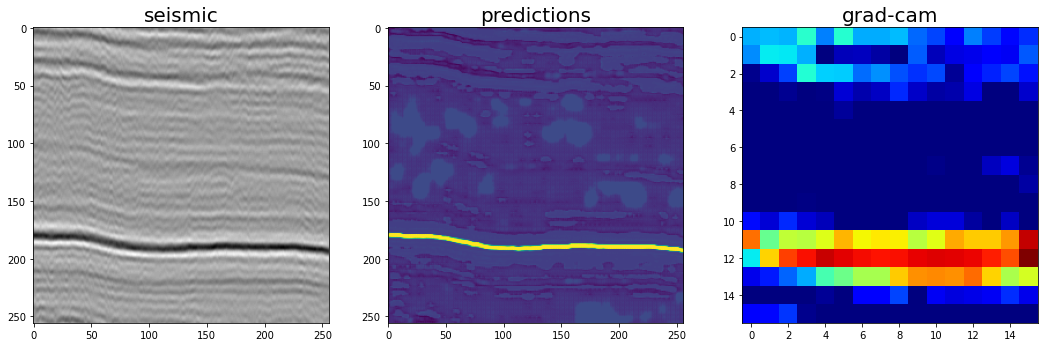

In [13]:
module = model.model[1][1]

cam = model.get_gradcam(images=batch.images[0:1], gradient_mode=batch.masks[0:1], layer=module)

plot_image((batch.images[0], batch.predictions[0], cam), mode='separate', cmap=['gray', 'viridis', 'jet'], t='',
           titles=['seismic', 'predictions', 'grad-cam'],
           savepath=f'{SAVEDIR}/cam_embedding')

## GradCam: decoder block-0

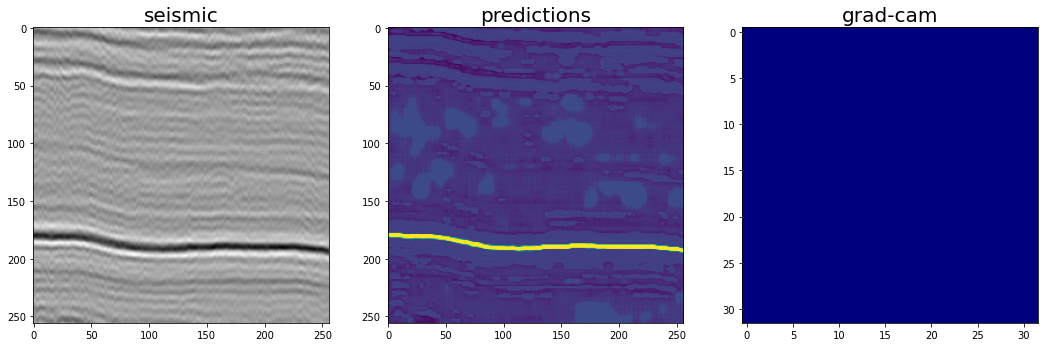

In [14]:
module = model.model[1][2]['block-0']

cam = model.get_gradcam(images=batch.images[0:1], gradient_mode=batch.masks[0:1], layer=module)

plot_image((batch.images[0], batch.predictions[0], cam), mode='separate', cmap=['gray', 'viridis', 'jet'], t='',
           titles=['seismic', 'predictions', 'grad-cam'],
           savepath=f'{SAVEDIR}/cam_decoder_0')

## GradCam: decoder block-1

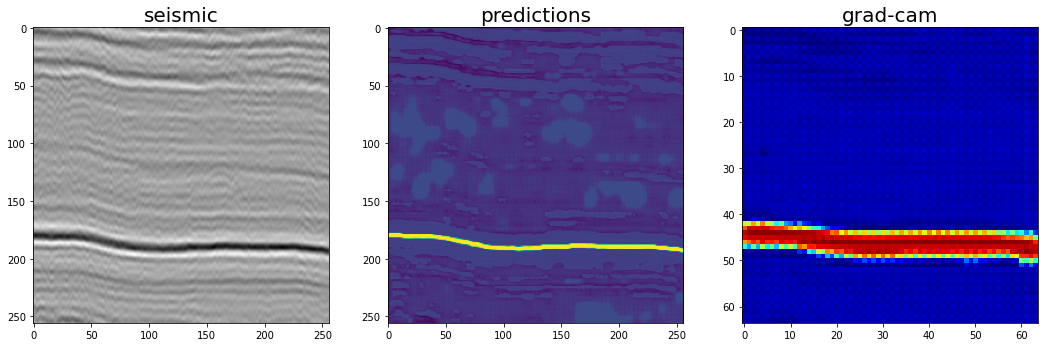

In [15]:
module = model.model[1][2]['block-1']

cam = model.get_gradcam(images=batch.images[0:1], gradient_mode=batch.masks[0:1], layer=module)

plot_image((batch.images[0], batch.predictions[0], cam), mode='separate', cmap=['gray', 'viridis', 'jet'], t='',
           titles=['seismic', 'predictions', 'grad-cam'],
           savepath=f'{SAVEDIR}/cam_decoder_1')

We can clearly see that, the deeper we are into the network, the more focused target horizon is. Despite that, on early layers, model learns to detect a huge number of seismic reflections, which can be leveraged into our future architectures.